In [ ]:
!pip install efficientnet-pytorch

import torch
import random
import torch.nn as nn
import torch.nn.functional as F
from torchvision.utils import save_image
import os
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from torch.utils.data import random_split
from efficientnet_pytorch import EfficientNet
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from torch.optim.lr_scheduler import StepLR

  Preparing metadata (setup.py) ... done
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
     ━━━━━━━

In [ ]:
class MelanomaModel(nn.Module):
    def __init__(self, out_size, dropout_prob=0.5):
        super(MelanomaModel, self).__init__()
        self.efficient_net = EfficientNet.from_pretrained('efficientnet-b0')
        self.efficient_net._fc = nn.Identity()  # Remove the original fully connected layer
        self.fc1 = nn.Linear(1280, 512)  # EfficientNet-b0 output features
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, out_size)
        self.dropout = nn.Dropout(dropout_prob)  # Dropout layer
        self.loss_fn = nn.CrossEntropyLoss()  # Assuming classification task

    def forward(self, x):
        x = self.efficient_net(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

# Instantiate model
num_classes = 9 # Number of classes

from google.colab import drive
drive.mount('/content/drive')

# Load the saved model and weights from Google Drive
file_path = '/content/drive/MyDrive/Melanoma_EfficientNet/MultiClass/EfficientNet_MultiClass_weight.pth'
checkpoint = torch.load(file_path, map_location=torch.device('cpu'))
model = checkpoint['architecture']
model.load_state_dict(checkpoint['model_state_dict'])

# Move the model to the appropriate device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)
model.eval()

print("Model and weights have been loaded from Google Drive:", file_path)

Mounted at /content/drive
Model and weights have been loaded from Google Drive: /content/drive/MyDrive/Melanoma_EfficientNet/MultiClass/EfficientNet_MultiClass_weight.pth


In [ ]:
data_transforms = transforms.Compose([
        transforms.Resize((244,244)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])


test_dataset = datasets.ImageFolder('/content/drive/MyDrive/Melanoma_EfficientNet/MultiClass/MultiClassTest/Multiclass_testdataset', transform=data_transforms)
PGD_dataset = datasets.ImageFolder('/content/drive/MyDrive/Melanoma_EfficientNet/MultiClass/MultiClassTest/Multiclass_adv_testdataset_PGD', transform=transforms.ToTensor())
BIM_dataset = datasets.ImageFolder('/content/drive/MyDrive/Melanoma_EfficientNet/MultiClass/MultiClassTest/Multiclass_adv_testdataset_BIM', transform=transforms.ToTensor())
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=12)
PGD_loader = DataLoader(PGD_dataset, batch_size=32, shuffle=False, num_workers=12)
BIM_loader = DataLoader(BIM_dataset, batch_size=32, shuffle=False, num_workers=12)
class_names_test = test_dataset.classes
class_names_PGD = PGD_dataset.classes
class_names_FGSM = BIM_dataset.classes


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
def predict_image(model, dataloader, device, class_names):
    model.eval()
    all_preds = []
    all_labels = []
    all_acc = []
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            accuracy = (torch.tensor(all_preds) == torch.tensor(all_labels)).float().mean().item()
            all_acc.append(accuracy)

    accuracy = sum(all_acc) / len(all_acc)
    return all_preds, all_labels, accuracy

# Get predictions, labels, and accuracy for the test set
predictions, labels, accuracy = predict_image(model, test_loader, device, class_names_test)
predictions_PGD, labels_PGD, accuracy_PGD = predict_image(model, PGD_loader, device, class_names_PGD)
predictions_BIM, labels_BIM, accuracy_BIM = predict_image(model, BIM_loader, device, class_names_FGSM)


In [ ]:
print(f"Test Accuracy: {100*(accuracy):.4f}%")

Test Accuracy: 89.5322%


In [ ]:
# Load the test dataset and adversarial datasets
test_dataset = datasets.ImageFolder('/content/drive/MyDrive/Melanoma_EfficientNet/MultiClass/MultiClassTest/Multiclass_testdataset', transform=data_transforms)
bim_dataset = datasets.ImageFolder('/content/drive/MyDrive/Melanoma_EfficientNet/MultiClass/MultiClassTest/Multiclass_adv_testdataset_BIM', transform=transforms.ToTensor())
pgd_dataset = datasets.ImageFolder('/content/drive/MyDrive/Melanoma_EfficientNet/MultiClass/MultiClassTest/Multiclass_adv_testdataset_PGD', transform=transforms.ToTensor())

test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True, num_workers=4)
bim_loader = DataLoader(bim_dataset, batch_size=32, shuffle=True, num_workers=4)
pgd_loader = DataLoader(pgd_dataset, batch_size=32, shuffle=True, num_workers=4)
class_names = test_dataset.classes

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
import numpy as np
# SVD Functions from Image
def find_index_singular_value(image):
    image_array = np.array(image)

    U, S, V = np.linalg.svd(image_array, full_matrices=False)

    normalized_singular_values = S / np.sum(S)
    cumulative_sum = np.cumsum(normalized_singular_values)
    cumulative_energy = 100 * cumulative_sum

    threshold = 0.9 * np.max(cumulative_energy)
    index = np.argmax(cumulative_energy >= threshold)

    return threshold

def svd_reconstruction(channel):
    U, S, V = np.linalg.svd(channel, full_matrices=False)
    S_filtered = np.where(S < find_index_singular_value(channel), 0, S)
    reconstructed_channel = U.dot(np.diag(S_filtered)).dot(V)
    return reconstructed_channel

# Function to apply SVD on each channel
def apply_svd(image):
    image_svd = np.zeros_like(image)
    for c in range(image.shape[0]):
        image_svd[c] = svd_reconstruction(image[c])
    return image_svd

# Function to predict image
def predict_image(model, image, device):
    model.eval()
    with torch.no_grad():
        image = image.to(device)
        output = model(image.unsqueeze(0))
        _, pred = torch.max(output, 1)
    return pred.item()

True label: 1, Predicted before SVD: 1, Predicted after SVD: 2
True label: 1, Predicted before SVD: 4, Predicted after SVD: 1
True label: 1, Predicted before SVD: 2, Predicted after SVD: 1


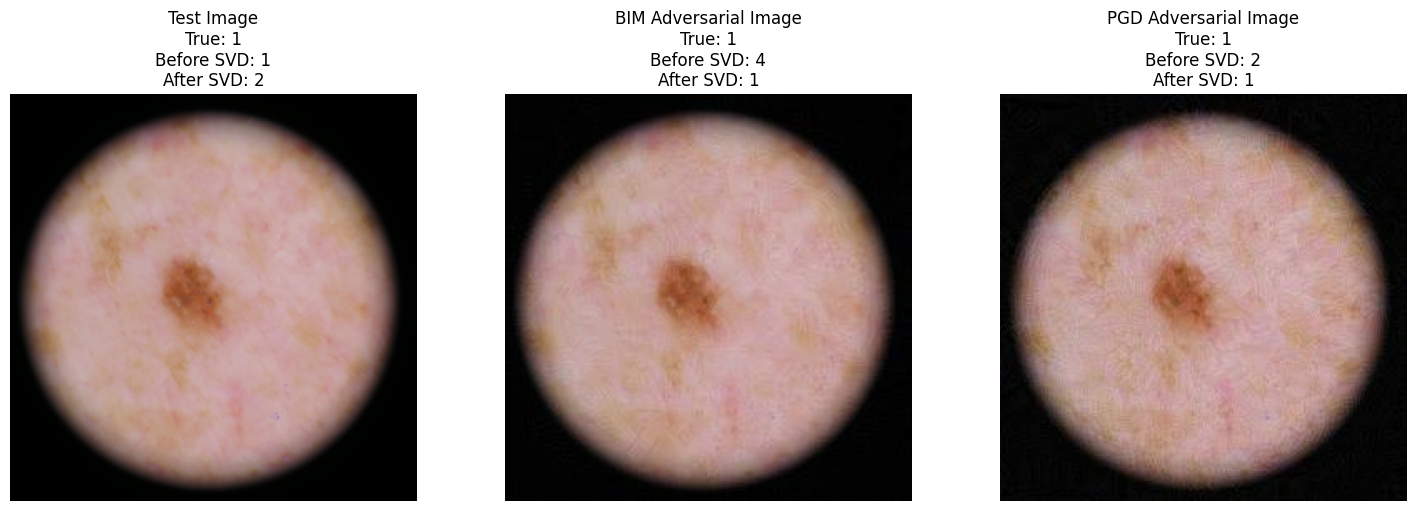

In [ ]:
# Select one random image from the test dataset
random_idx = 6001
test_image, test_label = test_dataset[random_idx]

# Select corresponding BIM and PGD adversarial images
bim_image, _ = bim_dataset[random_idx]
pgd_image, _ = pgd_dataset[random_idx]

# Get predictions before SVD
test_pred_before = predict_image(model, test_image, device)
bim_pred_before = predict_image(model, bim_image, device)
pgd_pred_before = predict_image(model, pgd_image, device)

# Apply SVD and reconstruct images
test_image_svd = torch.tensor(apply_svd(test_image.numpy())).to(device)
bim_image_svd = torch.tensor(apply_svd(bim_image.numpy())).to(device)
pgd_image_svd = torch.tensor(apply_svd(pgd_image.numpy())).to(device)

# Get predictions after SVD
test_pred_after = predict_image(model, test_image_svd, device)
bim_pred_after = predict_image(model, bim_image_svd, device)
pgd_pred_after = predict_image(model, pgd_image_svd, device)

# Function to plot comparison
def denormalize_image(image, mean, std):
    mean = np.array(mean)
    std = np.array(std)
    image = image * std[:, None, None] + mean[:, None, None]
    return image

def plot_comparison(image, label, pred_before, pred_after, class_names, attack_type, ax, denormalize=False):
    true_label = class_names[label]
    pred_before = class_names[pred_before]
    pred_after = class_names[pred_after]

    print(f'True label: {true_label}, Predicted before SVD: {pred_before}, Predicted after SVD: {pred_after}')

    # Plot original image
    img = image.numpy()
    if denormalize:
        img = denormalize_image(img, [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    npimg = np.transpose(img, (1, 2, 0))
    ax.imshow(npimg)
    ax.set_title(f'{attack_type}\nTrue: {true_label}\nBefore SVD: {pred_before}\nAfter SVD: {pred_after}')
    ax.axis('off')

def plot_all_comparisons(test_image, bim_image, pgd_image, test_label, test_pred_before, test_pred_after,
                         bim_pred_before, bim_pred_after, pgd_pred_before, pgd_pred_after, class_names):
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))

    plot_comparison(test_image, test_label, test_pred_before, test_pred_after, class_names, "Test Image", axs[0], denormalize=True)
    plot_comparison(bim_image, test_label, bim_pred_before, bim_pred_after, class_names, "BIM Adversarial Image", axs[1])
    plot_comparison(pgd_image, test_label, pgd_pred_before, pgd_pred_after, class_names, "PGD Adversarial Image", axs[2])

    plt.tight_layout()
    plt.show()

plot_all_comparisons(test_image, bim_image, pgd_image, test_label, test_pred_before, test_pred_after,
                     bim_pred_before, bim_pred_after, pgd_pred_before, pgd_pred_after, class_names)


In [ ]:
import torch
import random
from tqdm import tqdm

# Assuming test_dataset, bim_dataset, and pgd_dataset are already loaded
test_predictions_before = []
test_predictions_after = []
bim_predictions_before = []
bim_predictions_after = []
pgd_predictions_before = []
pgd_predictions_after = []

# Process the first 25 images from each dataset
num_images_to_process = 6000
x=200
for i in tqdm(range(num_images_to_process,num_images_to_process+x)):
    # Get the original, BIM, and PGD images
    test_image, test_label = test_dataset[i]
    bim_image, _ = bim_dataset[i]
    pgd_image, _ = pgd_dataset[i]

    # Get predictions before SVD
    test_pred_before = predict_image(model, test_image, device)
    bim_pred_before = predict_image(model, bim_image, device)
    pgd_pred_before = predict_image(model, pgd_image, device)

    test_predictions_before.append((test_pred_before))
    bim_predictions_before.append((bim_pred_before))
    pgd_predictions_before.append((pgd_pred_before))

    # Apply SVD and reconstruct images
    test_image_svd = torch.tensor(apply_svd(test_image.numpy())).to(device)
    bim_image_svd = torch.tensor(apply_svd(bim_image.numpy())).to(device)
    pgd_image_svd = torch.tensor(apply_svd(pgd_image.numpy())).to(device)

    # Get predictions after SVD
    test_pred_after = predict_image(model, test_image_svd, device)
    bim_pred_after = predict_image(model, bim_image_svd, device)
    pgd_pred_after = predict_image(model, pgd_image_svd, device)

    test_predictions_after.append((test_pred_after))
    bim_predictions_after.append((bim_pred_after))
    pgd_predictions_after.append((pgd_pred_after))


100%|██████████| 200/200 [05:43<00:00,  1.72s/it]


In [ ]:
def calculate_changed_percentage(predictions_before, predictions_after):
    total = len(predictions_before)
    changed_count = sum(1 for before, after in zip(predictions_before, predictions_after) if before != after)
    return (changed_count / total) * 100

# Calculate percentages
test_changed_percentage = calculate_changed_percentage(test_predictions_before, test_predictions_after)
bim_changed_percentage = calculate_changed_percentage(bim_predictions_before, bim_predictions_after)
pgd_changed_percentage = calculate_changed_percentage(pgd_predictions_before, pgd_predictions_after)

print(f"Defense success in Test dataset: {test_changed_percentage:.2f}%")
print(f"Defense success in BIM dataset: {bim_changed_percentage:.2f}%")
print(f"Defense success in PGD dataset: {pgd_changed_percentage:.2f}%")

Defense success in Test dataset: 7.50%
Defense success in BIM dataset: 93.50%
Defense success in PGD dataset: 90.00%


In [ ]:
print(test_predictions_before)
print(test_predictions_after)
print(bim_predictions_before)
print(bim_predictions_after)
print(pgd_predictions_before)
print(pgd_predictions_after)

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 7, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 6, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 7, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [ ]:
import torch
import random
from tqdm import tqdm

# Assuming test_dataset, bim_dataset, and pgd_dataset are already loaded
test_predictions_before = []
test_predictions_after = []
bim_predictions_before = []
bim_predictions_after = []
pgd_predictions_before = []
pgd_predictions_after = []

# Process entire datasets
for i in tqdm(range(len(test_dataset))):
    # Get the original, BIM, and PGD images
    test_image, test_label = test_dataset[i]
    bim_image, _ = bim_dataset[i]
    pgd_image, _ = pgd_dataset[i]

    # Get predictions before SVD
    test_pred_before = predict_image(model, test_image, device)
    bim_pred_before = predict_image(model, bim_image, device)
    pgd_pred_before = predict_image(model, pgd_image, device)

    test_predictions_before.append((test_pred_before, test_label))
    bim_predictions_before.append((bim_pred_before, test_label))
    pgd_predictions_before.append((pgd_pred_before, test_label))

    # Apply SVD and reconstruct images
    test_image_svd = torch.tensor(apply_svd(test_image.numpy())).to(device)
    bim_image_svd = torch.tensor(apply_svd(bim_image.numpy())).to(device)
    pgd_image_svd = torch.tensor(apply_svd(pgd_image.numpy())).to(device)

    # Get predictions after SVD
    test_pred_after = predict_image(model, test_image_svd, device)
    bim_pred_after = predict_image(model, bim_image_svd, device)
    pgd_pred_after = predict_image(model, pgd_image_svd, device)

    test_predictions_after.append((test_pred_after, test_label))
    bim_predictions_after.append((bim_pred_after, test_label))
    pgd_predictions_after.append((pgd_pred_after, test_label))


In [ ]:
import torch
import random
from tqdm import tqdm

# Assuming test_dataset, bim_dataset, and pgd_dataset are already loaded
test_predictions_before = []
test_predictions_after = []
bim_predictions_before = []
bim_predictions_after = []
pgd_predictions_before = []
pgd_predictions_after = []

# Process the first 25 images from each dataset
num_images_to_process = 0
x=200
for i in tqdm(range(num_images_to_process,num_images_to_process+x)):
    # Get the original, BIM, and PGD images
    test_image, test_label = test_dataset[i]
    bim_image, _ = bim_dataset[i]
    pgd_image, _ = pgd_dataset[i]

    # Get predictions before SVD
    test_pred_before = predict_image(model, test_image, device)
    bim_pred_before = predict_image(model, bim_image, device)
    pgd_pred_before = predict_image(model, pgd_image, device)

    test_predictions_before.append((test_pred_before))
    bim_predictions_before.append((bim_pred_before))
    pgd_predictions_before.append((pgd_pred_before))

    # Apply SVD and reconstruct images
    test_image_svd = torch.tensor(apply_svd(test_image.numpy())).to(device)
    bim_image_svd = torch.tensor(apply_svd(bim_image.numpy())).to(device)
    pgd_image_svd = torch.tensor(apply_svd(pgd_image.numpy())).to(device)

    # Get predictions after SVD
    test_pred_after = predict_image(model, test_image_svd, device)
    bim_pred_after = predict_image(model, bim_image_svd, device)
    pgd_pred_after = predict_image(model, pgd_image_svd, device)

    test_predictions_after.append((test_pred_after))
    bim_predictions_after.append((bim_pred_after))
    pgd_predictions_after.append((pgd_pred_after))


100%|██████████| 200/200 [04:25<00:00,  1.33s/it]


In [ ]:
def calculate_changed_percentage(predictions_before, predictions_after):
    total = len(predictions_before)
    changed_count = sum(1 for before, after in zip(predictions_before, predictions_after) if before != after)
    return (changed_count / total) * 100

# Calculate percentages
test_changed_percentage = calculate_changed_percentage(test_predictions_before, test_predictions_after)
bim_changed_percentage = calculate_changed_percentage(bim_predictions_before, bim_predictions_after)
pgd_changed_percentage = calculate_changed_percentage(pgd_predictions_before, pgd_predictions_after)

print(f"Defense success in Test dataset: {test_changed_percentage:.2f}%")
print(f"Defense success in BIM dataset: {bim_changed_percentage:.2f}%")
print(f"Defense success in PGD dataset: {pgd_changed_percentage:.2f}%")

Defense success in Test dataset: 66.00%
Defense success in BIM dataset: 20.50%
Defense success in PGD dataset: 15.00%


In [ ]:
print(test_predictions_before)
print(test_predictions_after)
print(bim_predictions_before)
print(bim_predictions_after)
print(pgd_predictions_before)
print(pgd_predictions_after)

[0, 2, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 7, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 4, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 4, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 4, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]
[1, 0, 0, 1, 1, 1, 1, 1, 6, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 2, 2, 2, 1, 0, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 2, 2, 1, 2, 1, 2, 2, 2, 0, 7, 2, 1, 1, 2, 2, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 7, 1, 0, 1, 1, 2, 1, 6, 0, 1, 0, 1, 1, 7, 1, 2, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 6, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 2,

In [ ]:
import torch
import random
from tqdm import tqdm

# Assuming test_dataset, bim_dataset, and pgd_dataset are already loaded
test_predictions_before = []
test_predictions_after = []
bim_predictions_before = []
bim_predictions_after = []
pgd_predictions_before = []
pgd_predictions_after = []

# Process the first 25 images from each dataset
num_images_to_process = 7600
x=200
for i in tqdm(range(num_images_to_process,num_images_to_process+x)):
    # Get the original, BIM, and PGD images
    test_image, test_label = test_dataset[i]
    bim_image, _ = bim_dataset[i]
    pgd_image, _ = pgd_dataset[i]

    # Get predictions before SVD
    test_pred_before = predict_image(model, test_image, device)
    bim_pred_before = predict_image(model, bim_image, device)
    pgd_pred_before = predict_image(model, pgd_image, device)

    test_predictions_before.append((test_pred_before))
    bim_predictions_before.append((bim_pred_before))
    pgd_predictions_before.append((pgd_pred_before))

    # Apply SVD and reconstruct images
    test_image_svd = torch.tensor(apply_svd(test_image.numpy())).to(device)
    bim_image_svd = torch.tensor(apply_svd(bim_image.numpy())).to(device)
    pgd_image_svd = torch.tensor(apply_svd(pgd_image.numpy())).to(device)

    # Get predictions after SVD
    test_pred_after = predict_image(model, test_image_svd, device)
    bim_pred_after = predict_image(model, bim_image_svd, device)
    pgd_pred_after = predict_image(model, pgd_image_svd, device)

    test_predictions_after.append((test_pred_after))
    bim_predictions_after.append((bim_pred_after))
    pgd_predictions_after.append((pgd_pred_after))


100%|██████████| 200/200 [09:03<00:00,  2.72s/it]


In [ ]:
def calculate_changed_percentage(predictions_before, predictions_after):
    total = len(predictions_before)
    changed_count = sum(1 for before, after in zip(predictions_before, predictions_after) if before != after)
    return (changed_count / total) * 100

# Calculate percentages
test_changed_percentage = calculate_changed_percentage(test_predictions_before, test_predictions_after)
bim_changed_percentage = calculate_changed_percentage(bim_predictions_before, bim_predictions_after)
pgd_changed_percentage = calculate_changed_percentage(pgd_predictions_before, pgd_predictions_after)

print(f"Defense success in Test dataset: {test_changed_percentage:.2f}%")
print(f"Defense success in BIM dataset: {bim_changed_percentage:.2f}%")
print(f"Defense success in PGD dataset: {pgd_changed_percentage:.2f}%")

Defense success in Test dataset: 83.00%
Defense success in BIM dataset: 33.50%
Defense success in PGD dataset: 29.50%


In [ ]:
print(test_predictions_before)
print(test_predictions_after)
print(bim_predictions_before)
print(bim_predictions_after)
print(pgd_predictions_before)
print(pgd_predictions_after)

[6, 2, 3, 2, 2, 7, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 0, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 7, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 4, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 7, 4, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 5, 2, 2, 2, 2, 2, 2]
[1, 2, 1, 2, 1, 1, 1, 1, 1, 0, 1, 2, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 3, 3, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 6, 3, 3, 1, 2, 1, 1, 2, 0, 2, 3, 0, 1, 1, 3, 5, 3, 3, 2, 1, 1, 2, 1, 2, 3, 1, 1, 1, 2, 1, 3, 3, 1, 0, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 2, 1, 1, 3, 1, 1, 7, 1, 1, 1, 2, 1, 3, 1, 1, 1, 1, 1, 1, 1, 3, 3, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1,